In [6]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

def mlp_init(sizes, rng):
    params = []
    for i in range(len(sizes)-1):
        fan_in, fan_out = sizes[i], sizes[i+1]
        limit = np.sqrt(6/(fan_in+fan_out))
        W = rng.uniform(-limit, limit, size=(fan_in, fan_out))
        b = np.zeros((fan_out,))
        params.append((W, b))
    return params

def relu(x): return np.maximum(0, x)

def softmax(logits):
    logits = logits - np.max(logits, axis=-1, keepdims=True)
    e = np.exp(logits)
    return e / np.sum(e, axis=-1, keepdims=True)

class TinyMLP:
    def __init__(self, in_dim, hidden_dims, out_dim, rng):
        sizes = [in_dim] + list(hidden_dims) + [out_dim]
        self.params = mlp_init(sizes, rng)
        self.m = [ (np.zeros_like(W), np.zeros_like(b)) for (W,b) in self.params ]
        self.v = [ (np.zeros_like(W), np.zeros_like(b)) for (W,b) in self.params ]
        self.t = 0

    def forward(self, x):
        a = x
        cache = [a]
        preacts = []
        for i, (W,b) in enumerate(self.params):
            z = a @ W + b
            preacts.append(z)
            if i < len(self.params)-1:
                a = relu(z)
            else:
                a = z
            cache.append(a)
        return cache, preacts

    def predict(self, x):
        cache, _ = self.forward(x)
        return cache[-1]

    def adam_step(self, grads, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        new_params = []
        for i, ((dW, db), (W,b), (mW, mb), (vW, vb)) in enumerate(zip(grads, self.params, self.m, self.v)):
            mW = beta1*mW + (1-beta1)*dW
            mb = beta1*mb + (1-beta1)*db
            vW = beta2*vW + (1-beta2)*(dW*dW)
            vb = beta2*vb + (1-beta2)*(db*db)
            mW_hat = mW/(1-beta1**self.t)
            mb_hat = mb/(1-beta1**self.t)
            vW_hat = vW/(1-beta2**self.t)
            vb_hat = vb/(1-beta2**self.t)
            W = W - lr*mW_hat/(np.sqrt(vW_hat)+eps)
            b = b - lr*mb_hat/(np.sqrt(vb_hat)+eps)
            new_params.append((W,b))
            self.m[i] = (mW, mb)
            self.v[i] = (vW, vb)
        self.params = new_params

    def zero_grads(self):
        return [ (np.zeros_like(W), np.zeros_like(b)) for (W,b) in self.params ]

    def backward(self, x, grad_out):
        cache, preacts = self.forward(x)
        grads = self.zero_grads()
        da = grad_out  # shape (batch, out_dim)
        for i in reversed(range(len(self.params))):
            a_prev = cache[i]
            z = preacts[i]
            W, b = self.params[i]
            dW = a_prev.T @ da
            db = np.sum(da, axis=0)
            grads[i] = (dW, db)
            if i > 0:
                dz_prev = da @ W.T
                z_prev = preacts[i-1]
                da = dz_prev * (z_prev > 0)
        return grads

class PPOAgent:
    def __init__(self, state_dim, n_actions, hidden=(64,64), pi_lr=2.5e-4, vf_lr=2.5e-4,
                 gamma=0.99, lam=0.95, clip_ratio=0.2, entropy_coef=0.01, rng=None):
        self.rng = np.random.default_rng(rng)
        self.policy = TinyMLP(state_dim, list(hidden), n_actions, self.rng)
        self.value  = TinyMLP(state_dim, list(hidden), 1, self.rng)
        self.pi_lr = pi_lr
        self.vf_lr = vf_lr
        self.gamma = gamma
        self.lam = lam
        self.clip_ratio = clip_ratio
        self.entropy_coef = entropy_coef

    def act(self, state):
        logits = self.policy.predict(state[None,:])[0]
        probs = softmax(logits[None,:])[0]
        a = self.rng.choice(len(probs), p=probs)
        logp = np.log(probs[a] + 1e-8)
        v = self.value.predict(state[None,:])[0,0]
        return a, logp, v, probs

    def compute_gae(self, rewards, values, dones, gamma, lam):
        adv = np.zeros_like(rewards)
        lastgaelam = 0.0
        for t in reversed(range(len(rewards))):
            nonterminal = 1.0 - dones[t]
            vt = values[t]
            vtp1 = values[t+1] if t+1 < len(values) else 0.0
            delta = rewards[t] + gamma * vtp1 * nonterminal - vt
            lastgaelam = delta + gamma * lam * nonterminal * lastgaelam
            adv[t] = lastgaelam
        returns = adv + values[:-1]
        return adv, returns

    def update(self, states, actions, old_logps, returns, advantages, epochs=5, batch_size=64):
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        N = states.shape[0]
        idxs = np.arange(N)
        for _ in range(epochs):
            self.rng.shuffle(idxs)
            for start in range(0, N, batch_size):
                end = start + batch_size
                mb_idx = idxs[start:end]
                s = states[mb_idx]
                a = actions[mb_idx]
                old_lp = old_logps[mb_idx]
                ret = returns[mb_idx]
                adv = advantages[mb_idx]

                logits = self.policy.predict(s)
                probs = softmax(logits)
                pa = probs[np.arange(len(a)), a]
                logp = np.log(pa + 1e-8)
                entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1).mean()

                ratio = np.exp(logp - old_lp)
                surr1 = ratio * adv
                surr2 = np.clip(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * adv

                choose1 = (np.abs(surr1) <= np.abs(surr2)).astype(np.float32)
                eff = -(choose1 * ratio + (1-choose1) * np.clip(ratio, 1-self.clip_ratio, 1+self.clip_ratio)) * adv

                grad_logits = probs.copy()
                grad_logits[np.arange(len(a)), a] -= 1.0
                grad_logits *= (eff[:, None] / (pa[:, None] + 1e-8))

                logp_all = np.log(probs + 1e-8)
                grad_entropy = -(probs * (1 + logp_all))
                grad_entropy += probs * np.sum(probs * (1 + logp_all), axis=1, keepdims=True)
                grad_logits += -self.entropy_coef * grad_entropy

                policy_grads = self.policy.backward(s, grad_logits / max(1, len(mb_idx)))

                v_pred = self.value.predict(s)[:,0]
                dval = 2*(v_pred - ret)/max(1, len(mb_idx))
                dval = dval[:, None]
                value_grads = self.value.backward(s, dval)

                self.policy.adam_step(policy_grads, self.pi_lr)
                self.value.adam_step(value_grads, self.vf_lr)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [7]:

class CachingDecisionEnv:
    def __init__(self, rng=None):
        self.rng = np.random.default_rng(rng)
        self.max_steps = 200
        self.t = 0
        self.reset()

    @property
    def state_dim(self): return 4
    @property
    def n_actions(self): return 2

    def reset(self):
        self.t = 0
        self.pop = self.rng.uniform(0.1, 1.0)
        self.inv_storage = self.rng.uniform(0.05, 0.5)
        self.load = self.rng.uniform(0.2, 1.0)
        self.eff = self.rng.uniform(0.2, 1.0)
        return self._state()

    def _state(self):
        return np.array([self.pop, self.inv_storage, self.load, self.eff], dtype=np.float32)

    def step(self, action:int):
        cache = (action == 1)
        base_hit = np.clip(self.pop * (1.0/(1.0+self.load)), 0, 1)
        energy_cost = 0.2 + 0.3*self.load
        if cache:
            hit = base_hit + 0.25*self.eff
            energy_cost *= 0.6
            self.eff = np.clip(self.eff + 0.05*self.pop - 0.02*self.inv_storage, 0, 3)
            self.load = np.clip(self.load - 0.05*self.pop, 0, 3)
            self.inv_storage = np.clip(self.inv_storage + 0.01, 0, 1)
        else:
            hit = base_hit * 0.8
            energy_cost *= 1.0 + 0.2*self.pop
            self.load = np.clip(self.load + 0.02*self.pop, 0, 3)
            self.eff = np.clip(self.eff - 0.01, 0, 3)
        hit = np.clip(hit, 0, 1)
        reward = hit - energy_cost
        self.pop = np.clip(self.pop + self.rng.normal(0, 0.03), 0, 1.5)
        self.inv_storage = np.clip(self.inv_storage + self.rng.normal(0, 0.005), 0, 1)
        self.t += 1
        done = self.t >= self.max_steps
        return self._state(), float(reward), done, {"hit_prob": float(hit)}

class ContentUpdateEnv:
    def __init__(self, rng=None):
        self.rng = np.random.default_rng(rng)
        self.max_steps = 200
        self.t = 0
        self.reset()

    @property
    def state_dim(self): return 4
    @property
    def n_actions(self): return 2

    def reset(self):
        self.t = 0
        self.age = self.rng.uniform(0.2, 0.8)
        self.pop = self.rng.uniform(0.1, 1.0)
        self.inv_bw = self.rng.uniform(0.3, 1.5)
        self.eff = self.rng.uniform(0.2, 1.0)
        return self._state()

    def _state(self):
        return np.array([self.age, self.pop, self.inv_bw, self.eff], dtype=np.float32)

    def step(self, action:int):
        update = (action == 1)
        freshness_gain = self.pop * (self.age)
        latency_penalty = 0.1 + 0.4*self.inv_bw
        if update:
            reward = 0.8*freshness_gain - latency_penalty
            self.age = max(0.05, self.age*0.2)
            self.eff = np.clip(self.eff + 0.05*self.pop, 0, 3)
            self.inv_bw = np.clip(self.inv_bw + 0.05, 0, 2)
        else:
            staleness_pen = 0.5 * self.pop * max(0, self.age - 0.4)
            reward = -staleness_pen
            self.age = min(1.0, self.age + 0.03 + 0.02*self.pop)
            self.eff = np.clip(self.eff - 0.01*self.pop, 0, 3)
            self.inv_bw = np.clip(self.inv_bw - 0.02, 0, 2)
        self.pop = np.clip(self.pop + self.rng.normal(0, 0.03), 0, 1.5)
        self.t += 1
        done = self.t >= self.max_steps
        return self._state(), float(reward), done, {}


In [8]:

def collect_trajectories(env, agent:PPOAgent, steps:int):
    states, actions, logps, values, rewards, dones = [], [], [], [], [], []
    s = env.reset()
    for _ in range(steps):
        a, logp, v, _ = agent.act(s)
        s2, r, done, info = env.step(a)
        states.append(s); actions.append(a); logps.append(logp); values.append(v); rewards.append(r); dones.append(done)
        s = s2
        if done:
            s = env.reset()
    v_last = agent.value.predict(s[None,:])[0,0]
    values.append(v_last)
    return {
        "states": np.array(states, dtype=np.float32),
        "actions": np.array(actions, dtype=np.int64),
        "logps": np.array(logps, dtype=np.float32),
        "values": np.array(values, dtype=np.float32),
        "rewards": np.array(rewards, dtype=np.float32),
        "dones": np.array(dones, dtype=np.float32),
    }

def train(env, agent, total_steps=6000, update_every=2000, epochs=5, batch_size=128, verbose=True):
    stats = []
    steps_done = 0
    while steps_done < total_steps:
        data = collect_trajectories(env, agent, update_every)
        adv, rets = agent.compute_gae(data["rewards"], data["values"], data["dones"], agent.gamma, agent.lam)
        agent.update(data["states"], data["actions"], data["logps"], rets, adv, epochs=epochs, batch_size=batch_size)
        steps_done += update_every
        avg_ret = float(np.mean(rets))
        avg_rew = float(np.mean(data["rewards"]))
        stats.append({"steps": steps_done, "avg_return": avg_ret, "avg_reward": avg_rew})
        if verbose:
            print(f"[{steps_done}/{total_steps}] avg_return={avg_ret:.3f} avg_reward/step={avg_rew:.3f}")
    return stats


In [9]:

seed = 123
cache_env = CachingDecisionEnv(rng=seed+1)
agent1 = PPOAgent(state_dim=cache_env.state_dim, n_actions=cache_env.n_actions,
                  hidden=(64,64), pi_lr=2.5e-4, vf_lr=2.5e-4, gamma=0.99,
                  lam=0.95, clip_ratio=0.2, entropy_coef=0.01, rng=seed+2)
stats1 = train(cache_env, agent1, total_steps=4000, update_every=2000)

upd_env = ContentUpdateEnv(rng=seed+3)
agent2 = PPOAgent(state_dim=upd_env.state_dim, n_actions=upd_env.n_actions,
                  hidden=(128,128), pi_lr=1e-3, vf_lr=1e-3, gamma=0.95,
                  lam=0.95, clip_ratio=0.2, entropy_coef=0.02, rng=seed+4)
stats2 = train(upd_env, agent2, total_steps=4000, update_every=1000)

import pandas as pd
df1 = pd.DataFrame(stats1)
df2 = pd.DataFrame(stats2)
df1, df2


[2000/4000] avg_return=5.911 avg_reward/step=0.387
[4000/4000] avg_return=3.957 avg_reward/step=0.221
[1000/4000] avg_return=-3.791 avg_reward/step=-0.379
[2000/4000] avg_return=-10.506 avg_reward/step=-0.833
[3000/4000] avg_return=-12.864 avg_reward/step=-0.842
[4000/4000] avg_return=-14.331 avg_reward/step=-0.852


(   steps  avg_return  avg_reward
 0   2000    5.910643    0.387135
 1   4000    3.957012    0.221039,
    steps  avg_return  avg_reward
 0   1000   -3.790528   -0.378787
 1   2000  -10.506279   -0.833240
 2   3000  -12.864409   -0.842310
 3   4000  -14.330876   -0.852374)

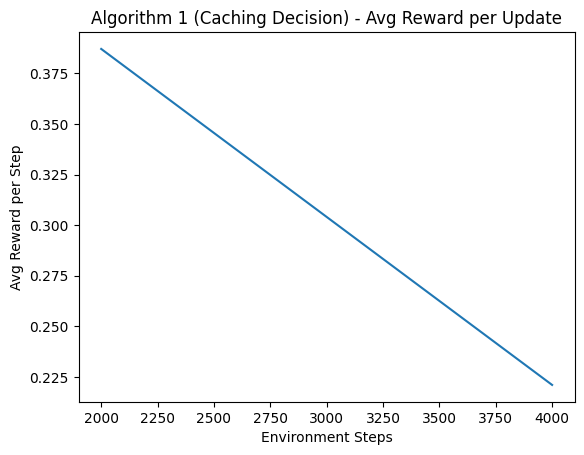

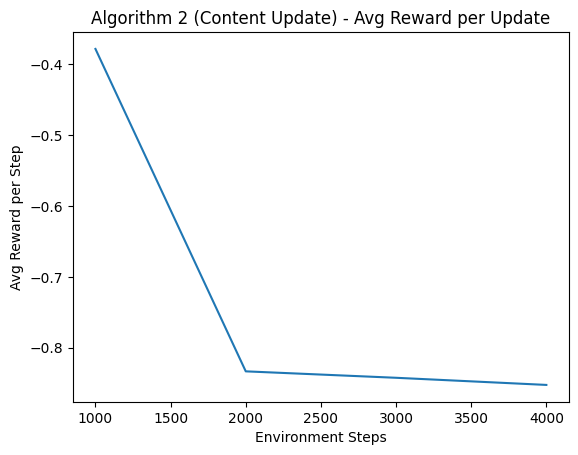

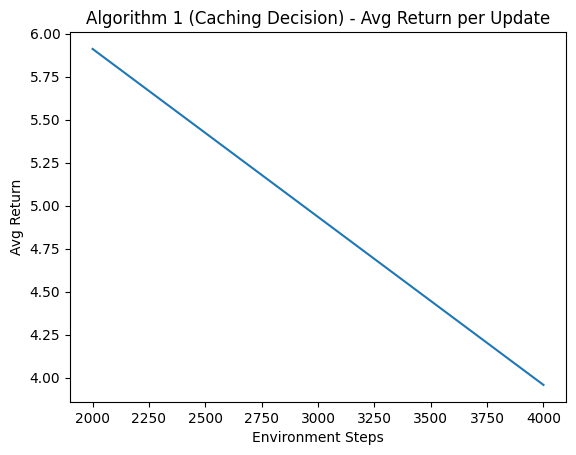

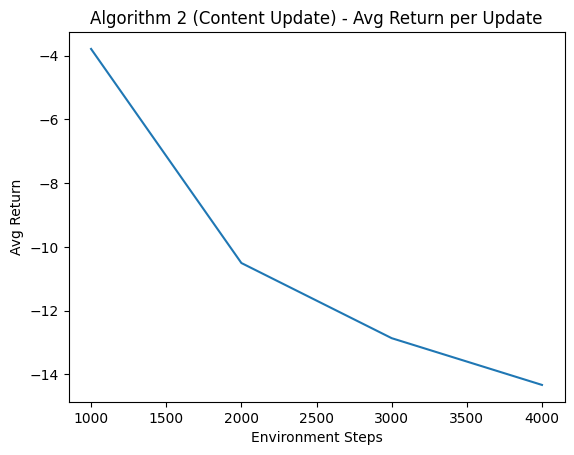

In [5]:

import matplotlib.pyplot as plt

# Plot 1: Algorithm 1 avg reward
plt.figure()
plt.plot(df1["steps"], df1["avg_reward"])
plt.title("Algorithm 1 (Caching Decision) - Avg Reward per Update")
plt.xlabel("Environment Steps")
plt.ylabel("Avg Reward per Step")
plt.show()

# Plot 2: Algorithm 2 avg reward
plt.figure()
plt.plot(df2["steps"], df2["avg_reward"])
plt.title("Algorithm 2 (Content Update) - Avg Reward per Update")
plt.xlabel("Environment Steps")
plt.ylabel("Avg Reward per Step")
plt.show()

# Plot 3: Algorithm 1 avg return
plt.figure()
plt.plot(df1["steps"], df1["avg_return"])
plt.title("Algorithm 1 (Caching Decision) - Avg Return per Update")
plt.xlabel("Environment Steps")
plt.ylabel("Avg Return")
plt.show()

# Plot 4: Algorithm 2 avg return
plt.figure()
plt.plot(df2["steps"], df2["avg_return"])
plt.title("Algorithm 2 (Content Update) - Avg Return per Update")
plt.xlabel("Environment Steps")
plt.ylabel("Avg Return")
plt.show()
